## Siamese Network

In [1]:
import os
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from PIL import Image
from pathlib import Path
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable


from fastai.vision import get_image_files
cuda = torch.cuda.is_available()

In [2]:
# Helper for removing the FC head of a network
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [3]:
data = Path("data")
train = pd.read_csv(data/'image_similarity_train.csv')
valid = pd.read_csv(data/'image_similarity_valid.csv')

In [4]:
class SiameseDataset(Dataset):
    """
    Based on: https://github.com/adambielski/siamese-triplet/blob/0c719f9e8f59fa386e8c59d10b2ddde9fac46276/datasets.py#L8
    
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, dataset):
        self.dataset = dataset

        self.train = self.dataset['train']
        self.transform = self.dataset['transform']

        if self.train:
            self.train_labels = self.dataset['labels']
            self.train_data = self.dataset['data']
            self.labels_set = set(self.train_labels)
            self.label_to_indices = {label: np.where(self.train_labels == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.dataset['labels']
            self.test_data = self.dataset['data']
            self.labels_set = set(self.test_labels)
            self.label_to_indices = {label: np.where(self.test_labels == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i]]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i]]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = Image.open(self.train_data[index]), self.train_labels[index]
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = Image.open(self.train_data[siamese_index])
        else:
            img1 = Image.open(self.test_data[self.test_pairs[index][0]])
            img2 = Image.open(self.test_data[self.test_pairs[index][1]])
            target = self.test_pairs[index][2]

        #img1 = Image.fromarray(img1.numpy(), mode='L')
        #img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)
        train_data = {
    'train': True,
    'transform': transforms.Compose([transforms.ToTensor()]),
    'df': train,
    'labels': np.array(train['Label']),
    'data': np.array(train['Path'])
}

valid_data = {
    'train': False,
    'transform': transforms.Compose([transforms.ToTensor()]),
    'df': valid,
    'labels': np.array(valid['Label']),
    'data': np.array(valid['Path'])
}

In [5]:
train_data = {
    'train': True,
    'transform': transforms.Compose([transforms.ToTensor()]),
    'df': train,
    'labels': np.array(train['Label']),
    'data': np.array(train['Path'])
}

valid_data = {
    'train': False,
    'transform': transforms.Compose([transforms.ToTensor()]),
    'df': valid,
    'labels': np.array(valid['Label']),
    'data': np.array(valid['Path'])
}

train_ds = SiameseDataset(train_data)
test_ds = SiameseDataset(valid_data)

In [6]:
batch_size = 16

siamese_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

Now we define a Siamese Network. It takes two images and returns the feature vector for each one by running it through an embedding network.

In [7]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [8]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

## Training

Now we must define the training loop for our network.

In [9]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics

def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics


In [10]:
margin = 1.

embedding_net = models.resnet18(pretrained=True)
embedding_net.fc = Identity()

model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/25680 (0%)]	Loss: 4443.990234
Train: [1600/25680 (6%)]	Loss: 30.501981
Train: [3200/25680 (12%)]	Loss: 0.329544
Train: [4800/25680 (19%)]	Loss: 0.140266
Train: [6400/25680 (25%)]	Loss: 0.110313
Train: [8000/25680 (31%)]	Loss: 0.102520
Train: [9600/25680 (37%)]	Loss: 0.096784
Train: [11200/25680 (44%)]	Loss: 0.098797
Train: [12800/25680 (50%)]	Loss: 0.074948
Train: [14400/25680 (56%)]	Loss: 0.074734
Train: [16000/25680 (62%)]	Loss: 0.068625
Train: [17600/25680 (69%)]	Loss: 0.066985
Train: [19200/25680 (75%)]	Loss: 0.067691
Train: [20800/25680 (81%)]	Loss: 0.062039
Train: [22400/25680 (87%)]	Loss: 0.059375
Train: [24000/25680 (93%)]	Loss: 0.059170
Train: [25600/25680 (100%)]	Loss: 0.054960
Epoch: 1/20. Train set: Average loss: 4.7608
Epoch: 1/20. Validation set: Average loss: 0.0308
Train: [0/25680 (0%)]	Loss: 0.081460
Train: [1600/25680 (6%)]	Loss: 0.050560
Train: [3200/25680 (12%)]	Loss: 0.055105
Train: [4800/25680 (19%)]	Loss: 0.050843
Train: [6400/25680 (25%)]	Loss: 0.05459

Train: [9600/25680 (37%)]	Loss: 0.014354
Train: [11200/25680 (44%)]	Loss: 0.010892
Train: [12800/25680 (50%)]	Loss: 0.011249
Train: [14400/25680 (56%)]	Loss: 0.012085
Train: [16000/25680 (62%)]	Loss: 0.011978
Train: [17600/25680 (69%)]	Loss: 0.011910
Train: [19200/25680 (75%)]	Loss: 0.011793
Train: [20800/25680 (81%)]	Loss: 0.011754
Train: [22400/25680 (87%)]	Loss: 0.010138
Train: [24000/25680 (93%)]	Loss: 0.011457
Train: [25600/25680 (100%)]	Loss: 0.010594
Epoch: 11/20. Train set: Average loss: 0.0118
Epoch: 11/20. Validation set: Average loss: 0.0069
Train: [0/25680 (0%)]	Loss: 0.008062
Train: [1600/25680 (6%)]	Loss: 0.010410
Train: [3200/25680 (12%)]	Loss: 0.011293
Train: [4800/25680 (19%)]	Loss: 0.011683
Train: [6400/25680 (25%)]	Loss: 0.010945
Train: [8000/25680 (31%)]	Loss: 0.011639
Train: [9600/25680 (37%)]	Loss: 0.010316
Train: [11200/25680 (44%)]	Loss: 0.009159
Train: [12800/25680 (50%)]	Loss: 0.010371
Train: [14400/25680 (56%)]	Loss: 0.009746
Train: [16000/25680 (62%)]	Loss: 

In [12]:
#Save the model
torch.save(model.state_dict(), "siamese_state_dict")
torch.save(embedding_net.state_dict(), "embedding_state_dict")

## Compare Images

Now that we've trained our model, let's use it to try to find similar images across both the training and test sets. For now we'll assume that similar images can exist across both sets or within a single set.

We can start by looking at two images we know are alike.

In [13]:
embedding_net = models.resnet18(pretrained=True)
embedding_net.fc = Identity()
embedding_net.load_state_dict(torch.load("embedding_state_dict"))
embedding_net = embedding_net.eval().cuda()

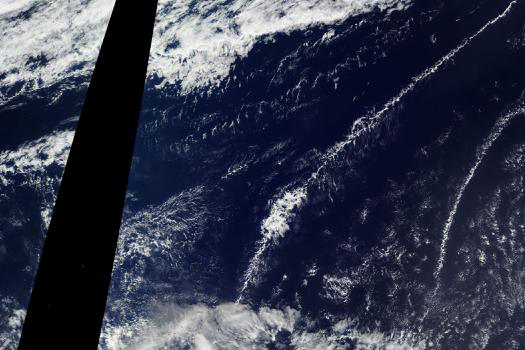

In [14]:
#load images 
img_path1 = 'data/train_images_350x525/ee0ba55.jpg'
img1 = Image.open(img_path1)
img1

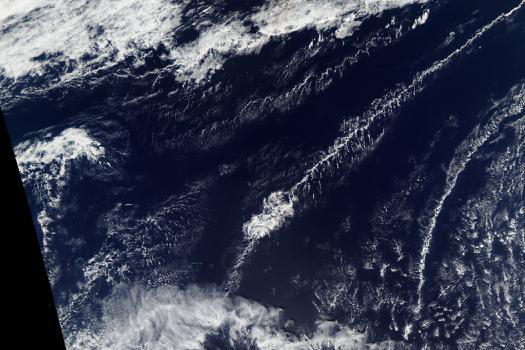

In [15]:
img_path2 = 'data/test_images_350x525/5383dcf.jpg'
img2 = Image.open(img_path2)
img2

In [16]:
def get_embedding_from_path(img_path):
    #load image
    img = Image.open(img_path)

    #convert to tensor
    x = transforms.ToTensor()(img).unsqueeze(0).cuda()

    #send through model
    out = embedding_net(x).detach()
    
    return out

In [17]:
def get_embeddings_from_paths(paths):
    """
    Get all embeddings for the images in a list of paths
    """
    embeddings = []

    for img in tqdm(paths):
        embedding = get_embedding_from_path(img).cpu().numpy()
        embeddings.append(embedding)

    embeddings = np.array(embeddings).squeeze()
    return embeddings

In [18]:
TRAIN_FOLDER = 'data/train_images_350x525/'
TEST_FOLDER = 'data/test_images_350x525/'
train_images = get_image_files(TRAIN_FOLDER)
test_images = get_image_files(TEST_FOLDER)

In [19]:
train_embeddings = get_embeddings_from_paths(train_images)
train_embeddings.shape

100%|██████████| 5546/5546 [00:45<00:00, 121.01it/s]


(5546, 28160)

In [20]:
test_embeddings = get_embeddings_from_paths(test_images)
test_embeddings.shape

100%|██████████| 3698/3698 [00:30<00:00, 121.33it/s]


(3698, 28160)

In [21]:
def get_distance_between_embeddings(embeddings1, embeddings2):
    """
    Given two sets of embeddings, calculate the distance between both
    """
    
    distance = np.zeros((len(embeddings1), len(embeddings2)))
    
    for i, row in enumerate(embeddings1):
        if i % 500 == 0:
            print(i, '/', len(embeddings1))

        row = row[np.newaxis,:]
        distance_row = np.sqrt(np.square(row - embeddings2).sum(axis=1))
        distance[i,:] = distance_row
        
    return distance

In [22]:
train_train_distances = get_distance_between_embeddings(train_embeddings, train_embeddings)

0 / 5546
500 / 5546
1000 / 5546
1500 / 5546
2000 / 5546
2500 / 5546
3000 / 5546
3500 / 5546
4000 / 5546
4500 / 5546
5000 / 5546
5500 / 5546


In [23]:
train_test_distances = get_distance_between_embeddings(train_embeddings, test_embeddings)

0 / 5546
500 / 5546
1000 / 5546
1500 / 5546
2000 / 5546
2500 / 5546
3000 / 5546
3500 / 5546
4000 / 5546
4500 / 5546
5000 / 5546
5500 / 5546


In [24]:
# Checkpoint
np.save("train_train_distances", train_train_distances)
np.save("train_test_distances", train_test_distances)

In [25]:
train_train_distances = np.load("train_train_distances.npy")
train_test_distances = np.load("train_test_distances.npy")

In [26]:
def find_similar_pairs(distances, threshold=0.185):
    pairs = []
    for i, row in enumerate(distances):
        
        sortedIndices = np.argsort(row)
        
        minIndex = sortedIndices[0]
        minVal = row[minIndex]
        
        secondMinIndex = sortedIndices[1]
        secondMinVal = row[secondMinIndex]

        if minVal < threshold and minVal != 0.0:
            pairs.append((i, minIndex))
        elif secondMinVal < threshold and secondMinVal != 0.0:
            # If the first value is 0.0 (eg. the image itself, try the second value)
            pairs.append((i, secondMinIndex))
            
    return pairs

In [27]:
train_train_pairs = find_similar_pairs(train_train_distances)
train_test_pairs = find_similar_pairs(train_test_distances)

In [28]:
for i in train_train_pairs[:10]:
    print(train_images[i[0]], "\n", train_images[i[1]], sep="")
    print()

data/train_images_350x525/3f611b8.jpg
data/train_images_350x525/81ba0e7.jpg

data/train_images_350x525/4aac315.jpg
data/train_images_350x525/ae47f2b.jpg

data/train_images_350x525/39fddf5.jpg
data/train_images_350x525/b4c8bbc.jpg

data/train_images_350x525/dcf0346.jpg
data/train_images_350x525/5036cdd.jpg

data/train_images_350x525/3e2dcff.jpg
data/train_images_350x525/617deb8.jpg

data/train_images_350x525/d578db5.jpg
data/train_images_350x525/38edef9.jpg

data/train_images_350x525/93bf66a.jpg
data/train_images_350x525/2107837.jpg

data/train_images_350x525/958d071.jpg
data/train_images_350x525/36b798f.jpg

data/train_images_350x525/8d940f5.jpg
data/train_images_350x525/7d07b86.jpg

data/train_images_350x525/4552f36.jpg
data/train_images_350x525/4cd1196.jpg



In [29]:
print(len(train_train_pairs))
print(len(train_test_pairs))

2664
2040


data/train_images_350x525/00498ec.jpg


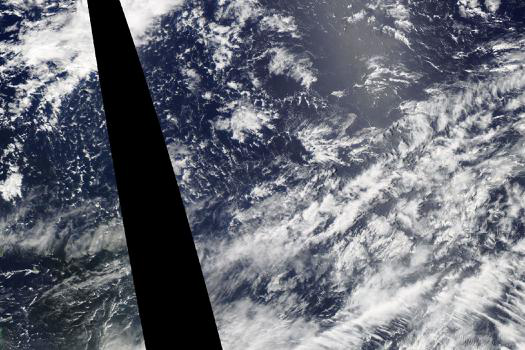

In [30]:
img_index = 2257
print(train_images[img_index])
Image.open(train_images[img_index])

data/test_images_350x525/b6ef544.jpg


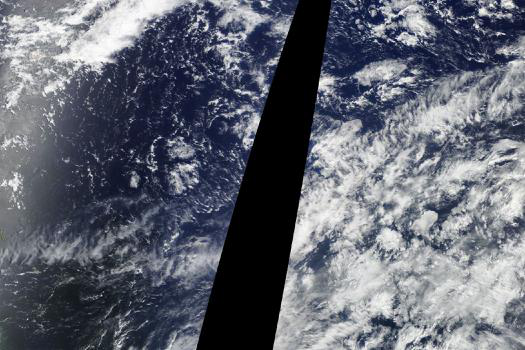

In [31]:
test_img_index = 660
print(test_images[test_img_index])
Image.open(test_images[test_img_index])